<a href="https://colab.research.google.com/github/mc-friday/hanghaeAI/blob/main/test_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [3주차] 기본과제: DistilBERT로 뉴스 기사 분류 모델 학습하기

In [ ]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets
!apt-get update -qq
!apt-get install fonts-nanum* -qq

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum-coding.
(Reading database ... 123657 files and directories currently installed.)
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
import time
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch import nn
from torch.optim import Adam
from transformers import DistilBertTokenizer, DistilBertModel
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import platform

## 1. [MY_CODE] 데이터셋 로드 (Load Dataset)

In [ ]:
# AG_News 데이터셋 로드 (Load AG_News dataset)
ds = load_dataset("fancyzhx/ag_news")
# 디바이스 설정 (Set device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

## 2. [MY_CODE] 텍스트 길이 분포 계산 (Text Length Distribution Calculation)

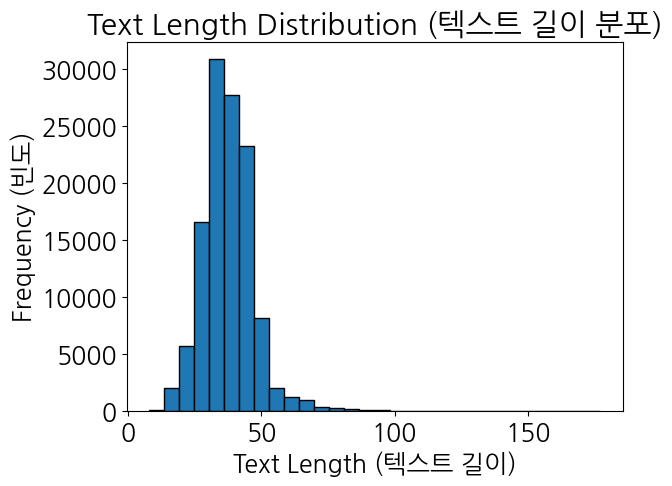

In [ ]:
# 한글 폰트 설정
import matplotlib.font_manager as fm
import warnings
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

# 각 텍스트의 길이를 계산하여 그래픽으로 표시
text_lengths = [len(sample['text'].split()) for sample in ds['train']]
plt.hist(text_lengths, bins=30, edgecolor='black')
plt.title("Text Length Distribution (텍스트 길이 분포)")
plt.xlabel("Text Length (텍스트 길이)")
plt.ylabel("Frequency (빈도)")
plt.show()

## 3. [MY_CODE] 토크나이저 준비 (Prepare Tokenizer)

In [ ]:
# DistilBERT의 토크나이저 로드 (Load DistilBERT tokenizer)
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

## 4. [MY_CODE] collate_fn 함수 정의 (Define collate_fn function)

In [ ]:
def collate_fn(batch):
    texts, labels = [], []
    for row in batch:
        labels.append(row['label'])  # 레이블은 0부터 3까지 유지 (Labels are kept as 0-3)
        texts.append(row['text'])

    # 텍스트를 토큰화하고 패딩 및 텐서 변환 (Tokenize texts with padding and convert to tensors)
    encoded = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    return encoded['input_ids'], encoded['attention_mask'], torch.tensor(labels, dtype=torch.long)

# DataLoader 정의 (Define DataLoader)
train_loader = DataLoader(ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn)

## 5. [MY_CODE] 모델 정의 (Define Model)

In [ ]:
# DistilBERT 기반의 텍스트 분류기 (Text classifier based on DistilBERT)
class TextClassifier(nn.Module):
    def __init__(self, num_classes=4):  # AG_News 데이터셋의 클래스 수 (Number of classes in AG_News dataset)
        super().__init__()
        self.encoder = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.classifier = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state[:, 0]  # CLS 토큰 (CLS token)
        return self.classifier(x)

## 6. [MY_CODE] 손실 함수 및 옵티마이저 정의

In [ ]:
model = TextClassifier(num_classes=4).to(device)

# Pre-trained encoder 고정 (Freeze pre-trained encoder)
for param in model.encoder.parameters():
    param.requires_grad = False

loss_fn = nn.CrossEntropyLoss()  # 다중 클래스 분류를 위한 손실 함수 (Loss function for multi-class classification)
optimizer = Adam(model.parameters(), lr=0.001)  # 옵티마이저 설정 (Set optimizer)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

## 7. [MY_CODE] 정확도 계산 함수 (Define Accuracy Function)

In [ ]:
def accuracy(model, dataloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for input_ids, attention_mask, labels in dataloader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


## 8. [MY_CODE] 학습 (Training Loop)

In [ ]:
print("[LOG] Training is starting... (학습을 시작합니다...)")

n_epochs = 10
train_losses = []  # 손실 값 저장 (Store loss values)
train_accuracies = []  # 훈련 정확도 저장 (Store training accuracies)
test_accuracies = []  # 테스트 정확도 저장 (Store test accuracies)

for epoch in range(n_epochs):
    start_time = time.time()  # Epoch 시작 시간 기록 (Record epoch start time)
    model.train()
    total_loss = 0
    for input_ids, attention_mask, labels in train_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)  # 평균 손실 (Average loss)
    train_acc = accuracy(model, train_loader)  # 훈련 정확도 계산 (Calculate training accuracy)
    test_acc = accuracy(model, test_loader)  # 테스트 정확도 계산 (Calculate test accuracy)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    epoch_time = time.time() - start_time  # Epoch 소요 시간 (Time taken for epoch)
    print(f"[LOG] Epoch {epoch + 1}/{n_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f} | Time: {epoch_time:.2f}s")


[LOG] Training is starting... (학습을 시작합니다...)
[LOG] Epoch 1/10 | Train Loss: 0.3536 | Train Acc: 0.8971 | Test Acc: 0.8970 | Time: 456.23s
[LOG] Epoch 2/10 | Train Loss: 0.2955 | Train Acc: 0.9018 | Test Acc: 0.9008 | Time: 453.98s
[LOG] Epoch 3/10 | Train Loss: 0.2879 | Train Acc: 0.9045 | Test Acc: 0.9011 | Time: 454.58s
[LOG] Epoch 4/10 | Train Loss: 0.2828 | Train Acc: 0.9062 | Test Acc: 0.9043 | Time: 453.98s
[LOG] Epoch 5/10 | Train Loss: 0.2796 | Train Acc: 0.9070 | Test Acc: 0.9039 | Time: 452.89s
[LOG] Epoch 6/10 | Train Loss: 0.2773 | Train Acc: 0.9074 | Test Acc: 0.9062 | Time: 453.71s
[LOG] Epoch 7/10 | Train Loss: 0.2769 | Train Acc: 0.9064 | Test Acc: 0.9026 | Time: 452.58s
[LOG] Epoch 8/10 | Train Loss: 0.2749 | Train Acc: 0.9080 | Test Acc: 0.9043 | Time: 452.33s
[LOG] Epoch 9/10 | Train Loss: 0.2739 | Train Acc: 0.9092 | Test Acc: 0.9070 | Time: 452.21s
[LOG] Epoch 10/10 | Train Loss: 0.2741 | Train Acc: 0.9092 | Test Acc: 0.9061 | Time: 453.10s


## 9. [MY_CODE] 시각화 (Visualization)

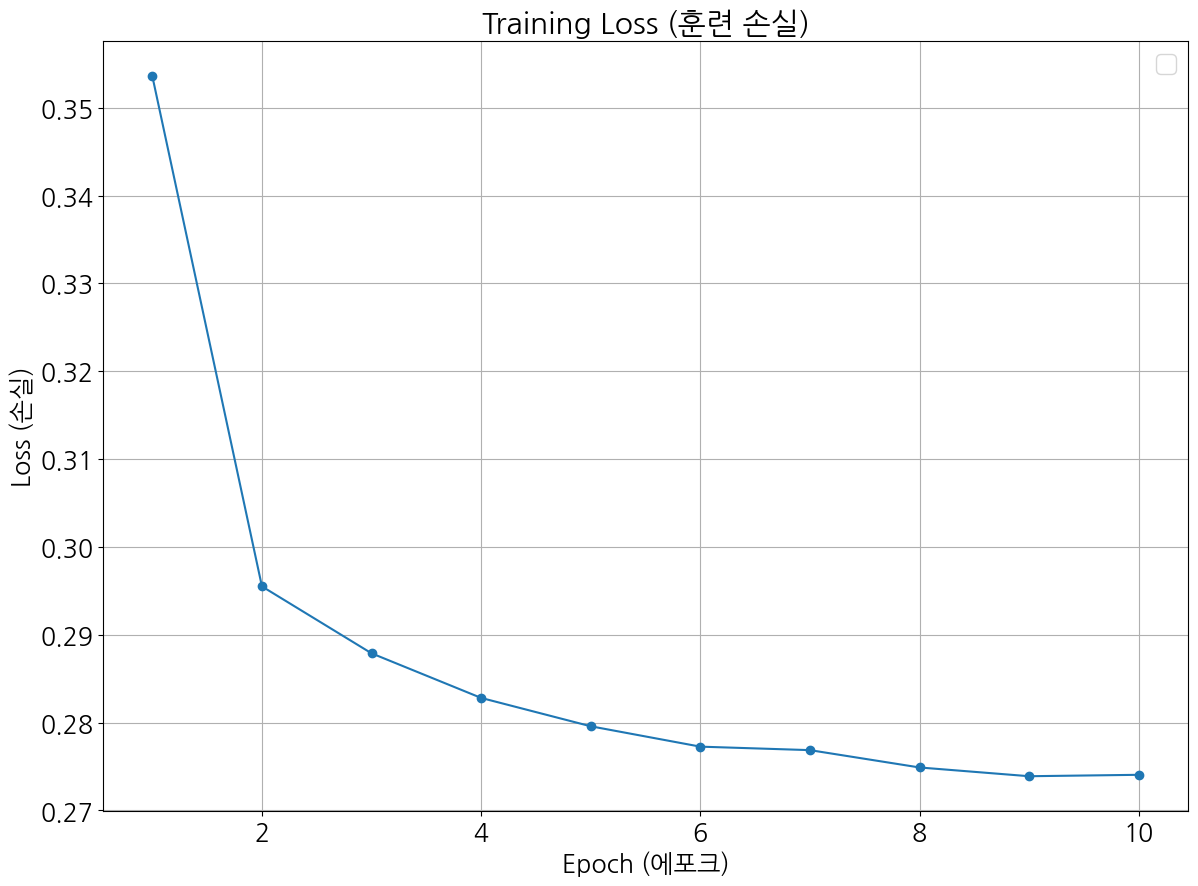

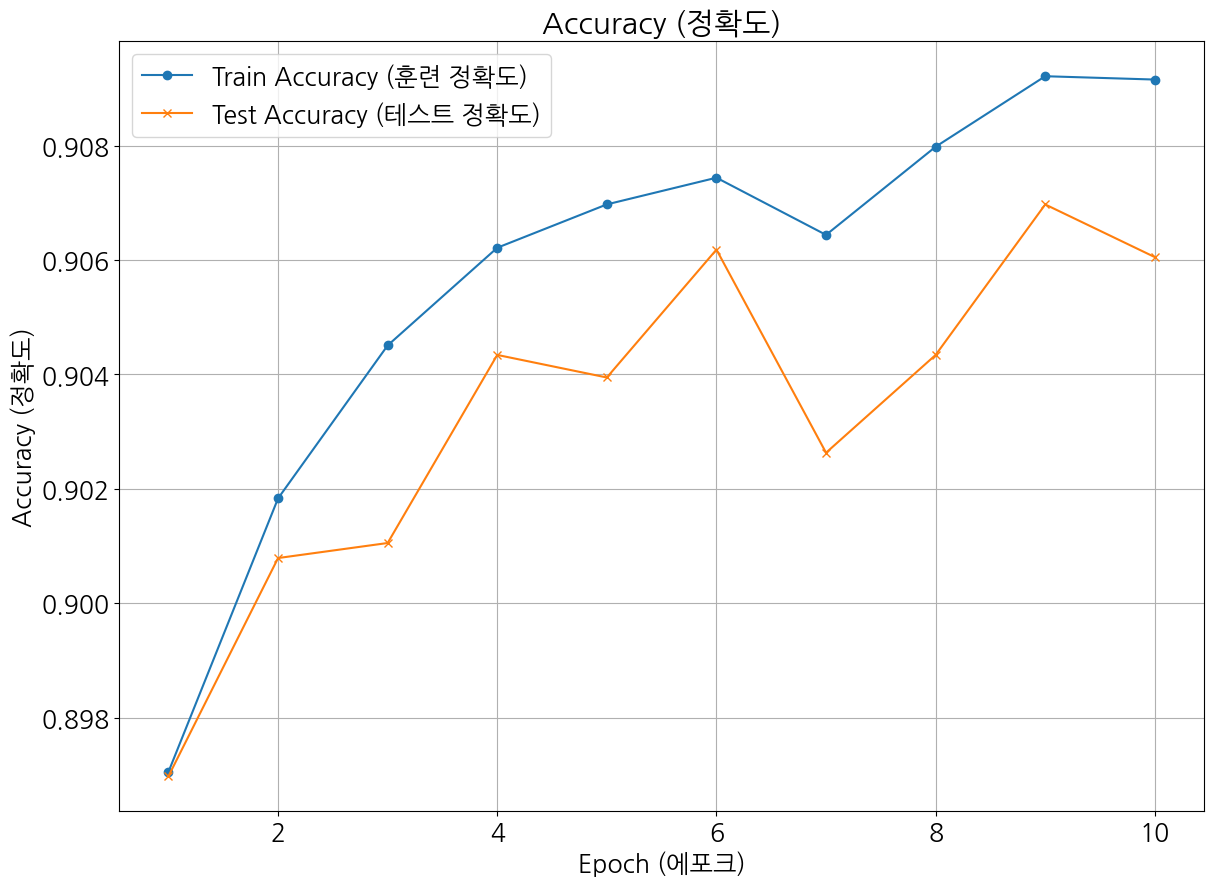

In [ ]:
# Loss 그래프 (Loss graph)
plt.figure(figsize=(14,10))
plt.plot(range(1, n_epochs + 1), train_losses, marker='o')
plt.title("Training Loss (훈련 손실)")
plt.xlabel("Epoch (에포크)")
plt.ylabel("Loss (손실)")
plt.legend()
plt.grid(True)
plt.show()
print("\n\n")

# Accuracy 그래프 (Accuracy graph)
plt.figure(figsize=(14,10))
plt.plot(range(1, n_epochs + 1), train_accuracies, label="Train Accuracy (훈련 정확도)", marker='o')
plt.plot(range(1, n_epochs + 1), test_accuracies, label="Test Accuracy (테스트 정확도)", marker='x')
plt.title("Accuracy (정확도)")
plt.xlabel("Epoch (에포크)")
plt.ylabel("Accuracy (정확도)")
plt.legend()
plt.grid(True)
plt.show()

## 10. [MY_CODE] 최종 로그 (Final Log)

In [ ]:
final_test_acc = accuracy(model, test_loader)
print(f"[LOG] Final Test Accuracy: {final_test_acc:.4f} (최종 테스트 정확도)")

[LOG] Final Test Accuracy: 0.9061 (최종 테스트 정확도)
